# Supervised Machine Learning on 2D Spectra (iris)

This notebook involves classifying 2D specs by utilizing Convolutional Neural Network. The pipeline includes preparing the dataset, evaluating the model, and predicting an unlabeled dataset with the model. If you already have a dataset which is labeled, skip the notebook to 'model testing'. If you have an unlabeled dataset, skip to 'predicting unlabeled data'.

In [7]:
import numpy as np
import pickle
import pandas as pd
from tqdm import tqdm, tqdm_notebook
import random
import time
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import PIL
from PIL import Image
import re
from sklearn.neighbors import NearestNeighbors
import glob
import matplotlib
import matplotlib.pyplot as plt
import plotly.io as pio
import matplotlib.image as mpimg
import io
import base64
import plotly.graph_objects as go
import plotly.offline as pyo
import plotly.graph_objs as go
import plotly.express as px
from IPython.display import display, HTML, clear_output
import ipywidgets as widgets
from ipywidgets import Output
from hetdex_api.elixer_widget_cls import ElixerWidget as EW
from IPython.display import Image as IPImage
from tqdm.keras import TqdmCallback
import tempfile
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import warnings
import tensorflow as tf
from sklearn.model_selection import train_test_split
import pickle
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from tensorflow.keras.models import load_model
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay
from astropy.visualization import ZScaleInterval
import os.path as op
from hetdex_api.config import HDRconfig
import tables
from astropy.table import QTable, Table, Column
warnings.filterwarnings("ignore", message="Configuration file not found")

## Data preparation

First, we load a machine learning catalog and a source catalog. The source catalog is filtered to select only the detections with certain flags. Then, we load a dataset containing normalized images (same process of making unsupervised ML arrays but without the flattening part), and assign labels to the images based on the detectid. All this information is then saved into a new pickle file.
Then we load the prepared dataset, split it into a training set and a testing set. The model is trained on 75% of the whole dataset.


In [ ]:
version = '3.0.3'
config = HDRconfig('hdr3')
# Load the machine learning catalog
mlfile = op.join( config.hdr_dir['hdr3'], 'catalogs','ml','detect_ml_3.0.3.h5')
fileh = tables.open_file(mlfile, 'r')
# Load the source catalog
catfile = op.join(config.hdr_dir['hdr3'], 'catalogs', 'source_catalog_' + version + '.fits')
detects_table = Table.read(catfile)

# Filter the detections
sel = ((detects_table['flag_best'] == 0) & (detects_table['flag_meteor'] == 1) & (detects_table['flag_largegal'] == 1))
flag_best_zero_ids = set(detects_table['detectid'][sel]) 
# Load the normalized images from the pickle file
with open('dataset.pickle', 'rb') as f:
    images_normalized, image_filenames = pickle.load(f)
# Label the files
labels = [1] * len(image_filenames) 
for i, filename in tqdm(enumerate(image_filenames), total=len(image_filenames), desc="Assigning labels"):
    detect_id = int(filename.replace('.png', ''))
    if detect_id in flag_best_zero_ids:
        labels[i] = 0

# Save the normalized images, filenames, and labels to a new pickle file
with open('dataset_CNN.pickle', 'wb') as f:
    pickle.dump((images_normalized, image_filenames, labels), f)
    
# Load the prepared dataset
with open('dataset_CNN.pickle', 'rb') as f:
    images_normalized, image_filenames, labels = pickle.load(f)

# Split the dataset into training and testing sets
images_normalized_train, images_normalized_test, filenames_train, filenames_test, labels_train, labels_test = train_test_split(
    images_normalized, image_filenames, labels, test_size=0.25, random_state=42)
with open('dataset_CNN_train.pickle', 'wb') as f:
    pickle.dump((images_normalized_train, filenames_train, labels_train), f)
with open('dataset_CNN_test.pickle', 'wb') as f:
    pickle.dump((images_normalized_test, filenames_test, labels_test), f)

## Model Testing
Next we start with loading the testing set and reshaping the input for the model. After loading the trained model, it predicts the labels of the testing set. It calculates the confusion matrix and several classification metrics and visualizes the confusion matrix. Based on the results, it classifies detections into TP (True Positive), FP (False Positive), TN (True Negative), and FN (False Negative). The classification results are then saved into a text file.


11603/11603 [==============================] - 111s 10ms/step
Confusion matrix:
 [[ 25673  24343]
 [  1934 319327]]
Precision:  0.9291675153490266
Recall:  0.9939799726701966
F1 score:  0.9604816138817411


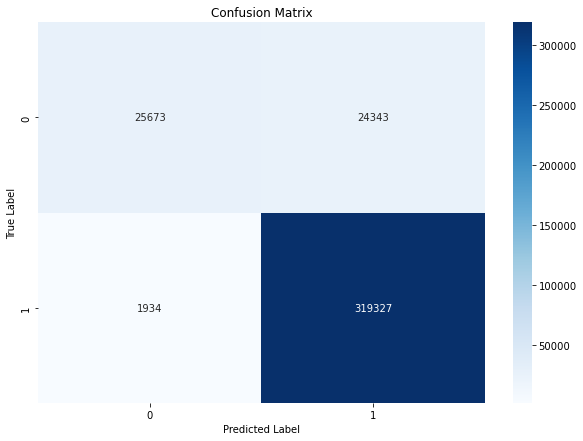

In [6]:
%matplotlib inline
# Load the testing dataset and reshape images_normalized_test for the model
with open('dataset_CNN_test.pickle', 'rb') as f:
    images_normalized_test, filenames_test, labels_test = pickle.load(f)
images_normalized_test = images_normalized_test.reshape(-1, 9, 100, 1)
labels_array_test = np.array(labels_test)

# Load the trained model
model = load_model('iris.h5')

# Predict the labels of the test set
y_pred = model.predict(images_normalized_test)
y_pred = np.round(y_pred).flatten()

# Calculate the confusion matrix
cm = confusion_matrix(labels_array_test, y_pred)
precision = precision_score(labels_array_test, y_pred)
recall = recall_score(labels_array_test, y_pred)
f1 = f1_score(labels_array_test, y_pred)
print('Confusion matrix:\n', cm)
print('Precision: ', precision)
print('Recall: ', recall)
print('F1 score: ', f1)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Extract detect IDs from filenames_test
detect_ids = [int(filename.replace('.png', '')) for filename in filenames_test]

# Classify detections into TP, FP, TN, FN
TP = [detect_ids[i] for i in range(len(labels_array_test)) if labels_array_test[i]==1 and y_pred[i]==1]
FP = [detect_ids[i] for i in range(len(labels_array_test)) if labels_array_test[i]==0 and y_pred[i]==1]
TN = [detect_ids[i] for i in range(len(labels_array_test)) if labels_array_test[i]==0 and y_pred[i]==0]
FN = [detect_ids[i] for i in range(len(labels_array_test)) if labels_array_test[i]==1 and y_pred[i]==0]

# Save the confusion matrix results
with open('confusion_matrix_ids_final.txt', 'w') as f:
    f.write("TP = " + str(TP) + "\n")
    f.write("FP = " + str(FP) + "\n")
    f.write("TN = " + str(TN) + "\n")
    f.write("FN = " + str(FN) + "\n")


## Predicting Unlabeled Data
Finally, we can load an the unlabeled dataset for the model. The trained model is then used to predict the labels. The predicted labels are rounded off and converted to integer type. They are also converted from numerical form to 'good' or 'junk'. A dataframe of filenames and predicted labels is then created, which is saved as a csv file.

In [13]:
#load the unlabeled dataset
with open('unlabeled.pickle', 'rb') as f:
    images_normalized, image_filenames = pickle.load(f)

# Reshape images_normalized for the model
images_normalized = images_normalized.reshape(-1, 9, 100, 1)
# Load the trained model
model = tf.keras.models.load_model('iris.h5')
# Use the trained model to predict labels of the unlabeled dataset
predictions = model.predict(images_normalized)

# Round off the predictions and convert them to integer type
predicted_labels = np.round(predictions).astype(int)

# Create a dataframe of filenames and predicted labels
df_predictions = pd.DataFrame({
    'Filename': image_filenames,
    'Predicted Label': predicted_labels.flatten()
})

# Convert numerical labels to 'good' or 'junk'
df_predictions['Predicted Label'] = df_predictions['Predicted Label'].apply(lambda x: 'good' if x == 1 else 'junk')

# Save the predictions to a csv file
df_predictions.to_csv('predictions.csv', index=False)
df = pd.read_csv('predictions.csv')
print(df)

625/625 [==============================] - 6s 10ms/step
             Filename Predicted Label
0      3000000106.png            good
1      3000000133.png            good
2      3000000134.png            good
3      3000000154.png            good
4      3000000240.png            junk
...               ...             ...
19995  3000602019.png            good
19996  3000602020.png            good
19997  3000602137.png            good
19998  3000602141.png            good
19999  3000602144.png            good

[20000 rows x 2 columns]


#### please don't hesitate to message me on Slack for any questions @Mahan Mirza Khanlari